In [1]:
import numpy as np
import os
import collections
import precision_recall_scores as roc
import matplotlib.pyplot as plt
import mpl_stylesheet
import subprocess

mpl_stylesheet.banskt_presentation(fontfamily = 'system')

chrm = 6

nsnp = {'chr1': 301817,
        'chr2': 324735,
        'chr3': 283158,
        'chr6': 272252}

key = f"chr{chrm}"
ntop = int(nsnp[key] * 0.01)

outdir = os.path.realpath(f"cardiogenics_mono_macro/matrixeqtl/chr{chrm}")
mapfile = os.path.realpath(f"/scratch/sbanerj/data/Cardiogenics/genotype_qc/CG_filtered_imputed_{chrm}.map")
mqtl1 = os.path.realpath(f"/scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-mono/matrixeqtl/chr{chrm}/trans_eqtl.txt")
mqtl2 = os.path.realpath(f"/scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-macro/matrixeqtl/chr{chrm}/trans_eqtl.txt")
rand1 = os.path.realpath(f"/scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-mono/matrixeqtl_rand/chr{chrm}/trans_eqtl.txt")
rand2 = os.path.realpath(f"/scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-macro/matrixeqtl_rand/chr{chrm}/trans_eqtl.txt")
bgenfile = os.path.realpath(f"/scratch/sbanerj/data/Cardiogenics/genotype_qc/CG_filtered_imputed_{chrm}.bgen")

ldstore = os.path.realpath(f"/usr/users/sbanerj/packages/ldstore/ldstore_v1.1_x86_64/ldstore")
ldmapscript = os.path.realpath(f"../scripts/create_ldmatrix_from_snps.sh")
plotscript = os.path.realpath(f"../scripts/plot_ldmap_validated_snps.py")

In [2]:
RESULT_FIELDS = ['rsid', 'target_genes', 'pvals', 'fdrs']
class MeQTLResult(collections.namedtuple('_MeQTLResult', RESULT_FIELDS)):
    __slots__ = ()
    
    @property
    def best_pval(self):
        return min(self.pvals)
    
    @property
    def best_fdr(self):
        return min(self.fdrs)
    
    def __repr__(self):
        parent_string = super(MeQTLResult, self).__repr__()
        return '{:s}, best_pval = {:g}, best_fdr = {:g}'.format(parent_string, self.best_pval, self.best_fdr)
    
SNPINFO_FIELDS = ['rsid', 'bp_location', 'ref_allele', 'alt_allele']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

def load_snpinfo(input_file):
    res = list()
    with open(input_file, 'r') as instream:
        for line in instream:
            mline = line.split()
            this_snp = SnpInfo(rsid = mline[1],
                               bp_location = int(mline[3]),
                               alt_allele = mline[4],
                               ref_allele = mline[5])
            res.append(this_snp)
    return res

def load_matrixeqtl_results(input_file):
    res = list()
    rsid_list = list()
    print( "Reading matrixEQTL from {:s}".format(input_file))
    with open(input_file) as instream:
        _ = instream.readline()
        for line in instream:
            arr  = line.rstrip().split("\t")
            rsid = arr[0]
            target_gene = arr[1]
            pval = float(arr[4])
            fdr  = float(arr[5])
            if rsid not in rsid_list:
                thisres = MeQTLResult(rsid = rsid,
                                      target_genes = [target_gene],
                                      pvals = [pval],
                                      fdrs = [fdr])
                res.append(thisres)
                rsid_list.append(rsid)
            else:
                lindex = rsid_list.index(rsid)
                target_genes = res[lindex].target_genes + [target_gene]
                #print(target_genes)
                pvals = res[lindex].pvals + [pval]
                fdrs = res[lindex].fdrs + [fdr]
                res[lindex] = res[lindex]._replace(target_genes = target_genes, pvals = pvals, fdrs = fdrs)
                #print("Replaced: ", res[lindex])
    return res

In [3]:
snpinfo = load_snpinfo(mapfile)

meqtl_dis = load_matrixeqtl_results(mqtl1)
meqtl_val = load_matrixeqtl_results(mqtl2)
rand_dis = load_matrixeqtl_results(rand1)
rand_val = load_matrixeqtl_results(rand2)

Reading matrixEQTL from /scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-mono/matrixeqtl/chr6/trans_eqtl.txt
Reading matrixEQTL from /scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-macro/matrixeqtl/chr6/trans_eqtl.txt
Reading matrixEQTL from /scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-mono/matrixeqtl_rand/chr6/trans_eqtl.txt
Reading matrixEQTL from /scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-macro/matrixeqtl_rand/chr6/trans_eqtl.txt


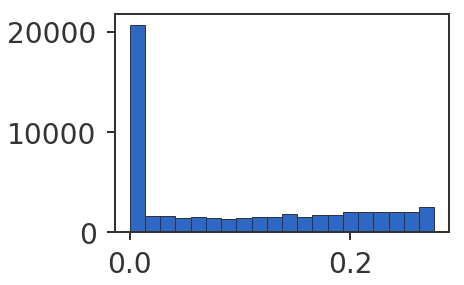

In [4]:
fdr = [x.best_fdr for x in meqtl_dis if x.best_fdr < 0.7]
plt.hist(fdr)
plt.show()

In [5]:
meqtl_dis_sorted = sorted(meqtl_dis, key=lambda x: x.best_pval)
meqtl_val_sorted = sorted(meqtl_val, key=lambda x: x.best_pval)
rand_dis_sorted  = sorted(rand_dis, key=lambda x: x.best_pval)
rand_val_sorted  = sorted(rand_val, key=lambda x: x.best_pval)

In [6]:
VALIDATION_FIELDS = ['rsid', 'target_genes', 'stat', 'causality']
class ValidationResult(collections.namedtuple('_ValidationResult', VALIDATION_FIELDS)):
    __slots__ = ()

def validate(dis, val, ntop=1000):
    res = list()
    valsnps = [x.rsid for x in val[:ntop]]
    for x in dis:
        thisres = None
        if x.rsid in valsnps:
            thisres = ValidationResult(rsid = x.rsid,
                                       target_genes = x.target_genes,
                                       stat = -np.log10(x.best_pval),
                                       causality = 1)
        else:
            thisres = ValidationResult(rsid = x.rsid,
                                       target_genes = x.target_genes,
                                       stat = -np.log10(x.best_pval),
                                       causality = 0)
        res.append(thisres)
    return res

In [7]:
valres = validate(meqtl_dis_sorted, meqtl_val_sorted, ntop)
fpr, tpr, ppv, nsel, fdr, tplist = roc.confusion_matrix(valres)
valres_r = validate(rand_dis_sorted, rand_val_sorted, ntop)
fpr_r, tpr_r, ppv_r, nsel_r, fdr, tplist_r = roc.confusion_matrix(valres_r)

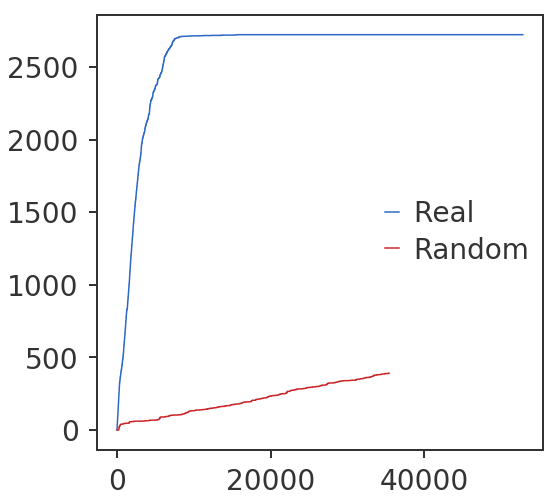

In [8]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot(nsel, tplist, label="Real")
ax1.plot(nsel_r, tplist_r, label="Random")
plt.legend()
plt.show()

In [9]:
target_genes = list()
tp = 0
for res in valres:
    if res.causality == 1:
        tp += 1
        target_genes += res.target_genes
muldef = [x for x in valres if len(x.target_genes) > 2 and x.causality == 1]
print(f"We found {tp} trans-eQTLs targeting {len(set(target_genes))} genes")
print(f"of which {len(muldef)} trans-eQTLs target more than 5 gene")

We found 2722 trans-eQTLs targeting 94 genes
of which 2519 trans-eQTLs target more than 5 gene


In [10]:
# Print list of rsids associated with the top target genes 
# "Top" target genes := controlled by maximum number of SNPs

target_genes = collections.defaultdict(lambda: 0)
tp = 0
for res in valres:
    if res.causality == 1:
        tp += 1
        this_target = res.target_genes
        for gene in this_target:
            target_genes[gene] += 1

top_genes = sorted(target_genes.items(), key=lambda x: x[1], reverse = True)[:10]

if not os.path.isdir(outdir): os.makedirs(outdir)
for gene in top_genes:
    gene_name = gene[0]
    rsid_list = [x.rsid for x in valres if gene_name in x.target_genes and x.causality == 1]
    outfile = os.path.join(outdir, f"{gene_name}.txt")
    with open(outfile, 'w') as ofile:
        for rsid in rsid_list:
            snp = [x for x in snpinfo if x.rsid == rsid][0]
            ofile.write(f"{snp.rsid} {snp.bp_location} {chrm} {snp.alt_allele} {snp.ref_allele} \n")

In [11]:
glist = f""
for gene in top_genes:
    glist = f"{glist} {gene[0]}"

myproc = (f"{ldmapscript} {ldstore} {plotscript} {chrm} 1 {bgenfile} {mqtl1} {outdir} {glist}")
print(myproc)
# subprocess.call(myproc, shell=True)

/home/mpg08/sbanerj/trans-eQTL/dev-pipeline/scripts/create_ldmatrix_from_snps.sh /home/mpg08/sbanerj/packages/ldstore/ldstore_v1.1_x86_64/ldstore /home/mpg08/sbanerj/trans-eQTL/dev-pipeline/scripts/plot_ldmap_validated_snps.py 6 1 /scratch/sbanerj/data/Cardiogenics/genotype_qc/CG_filtered_imputed_6.bgen /scratch/sbanerj/trans-eqtl/dev-pipeline/cardio-mono/matrixeqtl/chr6/trans_eqtl.txt /home/mpg08/sbanerj/trans-eQTL/dev-pipeline/devtools/cardiogenics_mono_macro/matrixeqtl/chr6  ENSG00000157404 ENSG00000169756 ENSG00000186470 ENSG00000023228 ENSG00000136250 ENSG00000204525 ENSG00000196735 ENSG00000101150 ENSG00000140995 ENSG00000157554
